<a href="https://colab.research.google.com/github/gamedaygeorge/datacube-applications-library/blob/odc-colab/DCAL_notebooks/DCAL_Cloud_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="top"></a>
# Cloud Statistics <img align="right" style="padding:10px" src="https://github.com/gamedaygeorge/datacube-applications-library/blob/master/images/odc_logo.png?raw=1">

This notebook explores Landsat-7 and Landsat-8 Data Cubes and reports cloud statistics for selected regions within a cube. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to find a single date when there are few clouds to assess land features.

What does this Notebook do?

* [Setup the Environment](#environment_setup)
* [Explore the Data](#explore_data)
* [Calculate Cloud Coverage Percentage](#calc_cloud_coverage)
* [Create and RGB Image of a Time Slice](#rgb_image)
* [Contributors, Heritage and References](#contributors_heritage)

This notebook uses external functions including both a standard set of DCAL utilities (see folder [DCAL_utils](../DCAL_utils)) and a code behind file containing some specalised functions that make this page work (see file [DCAL_Cloud_Statistics.py](DCAL_Cloud_Statistics.py)).

<i><p style="color:red"><b>Red Text:</b> Indicates code blocks where user inputs can be provided.</p></i>

<a id="environment_setup"></a>
## Environment Setup [&#9652;](#top)
* **Surpress Python Warnings:** These warnings include notes about deprecitation of Python modules, etc.
* **Import Standard Python Modules:** Import external and standard Python modules including `datacube` which is part of the ODC framework, as well as `xarray` which is a useful external module.
* **Import DCAL Utilities:** Import a set of utilities developed by the DCAL team to help automate some of the more routine tasks in the notebooks. These utilities are located in `/DCAL_utils`.
* **Initialize Data Cube and Data Cube API**

[Back to Top](#top)

In [1]:
# Clone GitHub repo for code behinds
!git clone -b odc-colab https://github.com/gamedaygeorge/datacube-applications-library.git

import os
os.chdir('/content/datacube-applications-library/DCAL_notebooks')
os.getcwd()

Cloning into 'datacube-applications-library'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (364/364), done.
remote: Compressing objects: 100% (273/273), done.
remote: Total 364 (delta 165), reused 239 (delta 75), pack-reused 0
Receiving objects: 100% (364/364), 18.47 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (165/165), done.


'/content/datacube-applications-library/DCAL_notebooks'

In [2]:
# Setup ODC on colab
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init()

--2020-11-12 02:10:01--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12518 (12K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  12.22K  --.-KB/s    in 0s      

2020-11-12 02:10:01 (43.4 MB/s) - ‘odc_colab.py’ saved [12518/12518]

Module datacube was not found; installing it...
Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Module hdmedians was not found; installing it...
Package postgresql was not found; installing it...


In [3]:
# Load ODC index
from odc_colab import populate_db
populate_db()

No database file supplied. Downloading default index.


In [4]:
# Supress Python Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Import Required Standard Python Modules
import datacube
import sys
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt

In [7]:
# Import notebook code behind (as cb) contaning function definitions specific to this notebook
import DCAL_Cloud_Statistics as cb

# Import DCAL utilities containing function definitions used generally across DCAL
# Add DCAL_utils to the sys.path
sys.path.append('../DCAL_utils')

# Import Data Cube API
import data_access_api as dc_api

# Import Display Map functions
from dc_display_map import display_map

In [8]:
# Load Data Cube Configuration
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

<a id="explore_data"></a>
## Explore Data [&#9652;](#top)
* **Select Product:** Specify the product you desire to use. Note you can see the complete list of products in this Cube in the introductory notebook (<a href="../Open%20Data%20Cube%20Application%20Library%20Notebooks.ipynb#products" target="_blank">click here</a>).
* **View Dataset Spatial and Temporal Extents:** Queries the Cube and displays the min/max latitude and longitude, and the start and end date and time.
* **Select Spatial and Temporal Extents:** Select the area of interest (AOI) and time range based on extents available.
* **Display the Area of Interest:** Renders a map of the AOI.

<p style="color:red";><b>Select Products:</b> Select Data Cube products based on what is available. (<a href="../OpenDataCube_Application_Library_Notebooks.ipynb#products" target="_blank" style="color:red">Click here to inspect available products</a>.)</p>

[Back to Top](#top)

In [9]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_ledaps_ghana"
# platform = "LANDSAT_7"

#product = "ls8_lasrc_ghana"
#platform = "LANDSAT_8"

# product = "ls8_lasrc_kenya"
# platform = "LANDSAT_8"

platform = 'LANDSAT_8'
product = 'ls8_usgs_sr_scene'

In [10]:
# Print spatial and temporal extents of the Data Cube
extents = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print('Data Cube latitude min ... max: ' + str(latitude_extents[0]) + ' ... ' + str(latitude_extents[1]))
print('Data Cube longitude min ... max: ' + str(longitude_extents[0]) + ' ... ' + str(longitude_extents[1]))

start_date_time = pd.to_datetime(str(time_extents[0]))
end_date_time = pd.to_datetime(str(time_extents[1]))

print('Start datetime: ' + start_date_time.strftime('%Y-%m-%d %H:%M:%S'))
print('End datetime: ' + end_date_time.strftime('%Y-%m-%d %H:%M:%S'))

Data Cube latitude min ... max: -12.633472222323292 ... 18.40152777792499
Data Cube longitude min ... max: -25.47236111131489 ... 44.00986111146319
Start datetime: 2013-03-21 08:18:02
End datetime: 2020-01-27 10:09:38


<p style="color:red";><b>Select Spatial and Temporal Extents:</b> Select the area of interest (AOI) and time range based on extents available.</p>

In [11]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Kumasi, Ghana
# latitude = (6.529, 6.8734) 
# longitude = (-1.7954, -1.4211)

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Mining Region near Obuasi, Ghana
#latitude = (6.0985, 6.2675)
#longitude = (-2.050, -1.8629)

# Mombasa, Kenya
latitude = (-4.12, -3.975)
longitude = (39.55, 39.7) 

# Time Period
time_extents = ('2016-01-01', '2016-12-31')

In [12]:
# Render a map of the Area of Interest.
display_map(latitude,longitude)

<a id="calc_cloud_coverage"></a>
## Calculate Cloud Coverage Percentage [&#9652;](#top)

* **Define Function:** to build a cloud coverage table for Landsat.
* **Build Cloud Coverage Table:** Call function to build Landsat dataset and cloud coverage table.
* **Create Table:** Create and print table of cloud coverage percentage for each date.
* **Plot:** Create a plot of cloud coverage percentage for each date.

[Back to Top](#top)

In [13]:
# Build landsat dataset and cloud coverage table (calling function in code behind)
# GD NOTES: What is the purpose of extra_band?
extra_band = 'green'
landsat_dataset, coverage_table = cb.build_cloud_coverage_table_landsat(product = product,
                                                                  platform = platform,
                                                                  latitude = latitude,
                                                                  longitude = longitude,
                                                                  time = time_extents,
                                                                  extra_band=extra_band)

In [14]:
# Create and print a table of cloud coverage percentage for each date
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2016-01-10 07:31:41.510529,0.000000,0
1,2016-01-26 07:31:41.904514,66.728634,188804
2,2016-03-14 07:31:27.626810,73.918422,209147
3,2016-03-30 07:31:17.510312,82.328950,232944
4,2016-05-01 07:31:14.033799,76.538737,216561
5,2016-05-17 07:31:11.492204,48.300541,136663
6,2016-06-02 07:31:17.385440,72.749635,205840
7,2016-06-18 07:31:20.323225,12.753099,36084
8,2016-07-04 07:31:29.807543,6.364886,18009
9,2016-07-20 07:31:36.081685,54.970082,155534


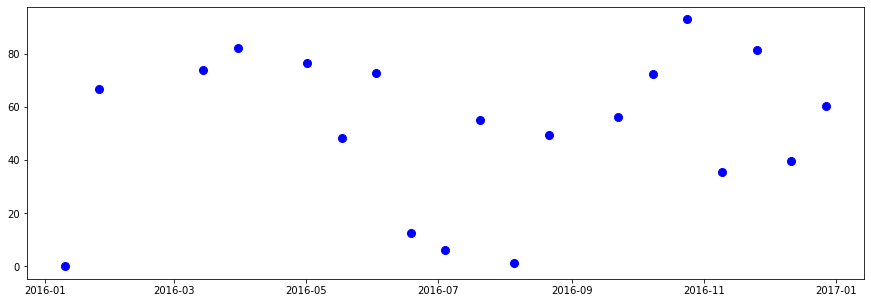

In [15]:
# Create a plot of cloud coverage percentage for each date.
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.show()

<a id="rgb_image"></a>
## Produce an RGB Image for a Selected Time Slice [&#9652;](#top)
* **Load Data:** Load the data to create an RGB image.
* **Print Dataset Summary:** Review the contents of the dataset.
* **Select Time Slice:** Select one of the time slices and create an RGB image.

[Back to top](#top)

In [16]:
# Load the data to create an RGB image
# GD NOTE: Why re-load landsat_dataset here? Can we just load landsat_dataset first time around with all measurements?
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2'],
                          group_by='solar_day') 

In [17]:
# Review the contents of the dataset
# Latitude and Longitude dimensions are in pixels
# Time dimension is the number of acquisitions in the time period
landsat_dataset

<xarray.Dataset>
Dimensions:      (latitude: 523, longitude: 541, time: 19)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-10T07:31:41.510529 ... 2016-12-27T07:31:51.423561
  * latitude     (latitude) float64 -3.975 -3.975 -3.975 ... -4.119 -4.12 -4.12
  * longitude    (longitude) float64 39.55 39.55 39.55 39.55 ... 39.7 39.7 39.7
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 6388 6458 6543 ... 49 59 54
    green        (time, latitude, longitude) int16 6355 6439 6513 ... 125 123
    blue         (time, latitude, longitude) int16 6318 6366 6467 ... 214 204
    nir          (time, latitude, longitude) int16 7000 7055 7135 ... 63 72 70
    swir1        (time, latitude, longitude) int16 4223 4276 4320 ... 97 97 92
    swir2        (time, latitude, longitude) int16 3292 3334 3367 ... 81 84 82
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

<p style="color:red";><b>Select Time Slice:</b> Update `slice` to an integer between 0 and landsat_dataset.dimensions.time minus 1.</p>

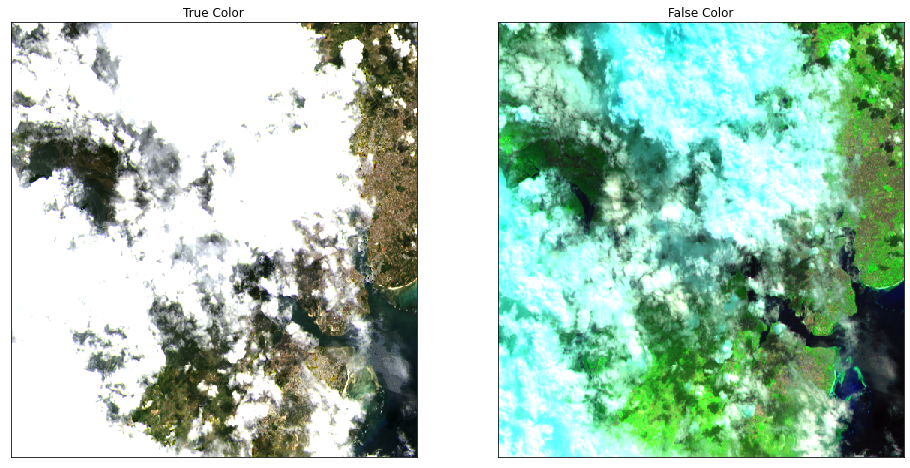

In [18]:
# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE for an RGB image

# RGB image options
# True-Color RGB = Red, Green, Blue
# False Color RGB (Landsat Mosaic) = SWIR2, NIR, Green

slice = 7 # select the time slice number here

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb = landsat_dataset.isel(time=slice)[['red', 'green', 'blue']].to_array()
false_rgb = landsat_dataset.isel(time=slice)[['swir2', 'nir', 'green']].to_array()
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=3000)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

<a id="contributors_heritage"></a>
## Contributors, Heritage and References [&#9652;](#top)
The notebooks liked here have been created by Brian Killough (NASA, CEOS Systems Engineering Office) in collaboration with a number of Open Data Cube (ODC) users from the Africian Regional Data Cube, Digital Earth Australia, and other ODC users globally.

GitHub repositories referenced/forked:

- https://github.com/ceos-seo/data_cube_utilities <i>A set of utilities maintained by the CEOS SEO team in support of the Notebooks being developed.</i>
- https://github.com/ceos-seo/data_cube_notebooks <i>A set of Notebooks maintained by the CEOS SEO team.</i>
- https://github.com/GeoscienceAustralia/dea-notebooks <i>Forked this repo to include / adapt the [Beginers_guide](https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Beginners_guide) Notebooks. Basis for adaptation was [George Dyke's fork](https://github.com/gamedaygeorge/dea-notebooks).</i>

<i><b>NOTE:</b> Digital Earth Africa has adapted this notebook to run on their platform. The code is <a href="https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/DCAL/DCAL_notebooks/DCAL_Cloud_Statistics.ipynb" target="_blank">available here</a>. Their implementation cleans up some of the rougher edges that remain in this notebook.</i>

Last updated May 2020.

[Back to top](#top)